In [1]:
import numpy as np
from scipy.optimize import root_scalar, minimize_scalar
from scipy.stats import norm  # Import the norm function
import math

### Intento preliminar multimétodo de chatgpt

In [2]:
# Black-Scholes formula for European call option
def black_scholes_call(S, K, r, T, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Function to minimize
def function_to_minimize(sigma, S, K, r, T, price):
    return (black_scholes_call(S, K, r, T, sigma) - price)

def function_to_minimize_derivative(sigma, S, K, r, T, price, dx=0.000001):
    # Approximate the derivative using central difference formula
    f_plus = function_to_minimize(sigma + dx, S, K, r, T, price)
    f_minus = function_to_minimize(sigma - dx, S, K, r, T, price)
    return (f_plus - f_minus) / (2 * dx)

def find_volatility(S, K, r, T, price, method='brent'):
    try:
        if method == 'brent':
            result = root_scalar(function_to_minimize, args=(S, K, r, T, price), bracket=(0.01, 2), method='brentq')
        elif method == 'newton':
            result = root_scalar(function_to_minimize, args=(S, K, r, T, price), x0=0.1, fprime=function_to_minimize_derivative, method='newton')
        elif method == 'golden':
            result = minimize_scalar(function_to_minimize, args=(S, K, r, T, price), bounds=(0.01, 2), method='golden')
        elif method == 'bounded':
            result = minimize_scalar(function_to_minimize, args=(S, K, r, T, price), bounds=(0.01, 2), method='bounded')
        
        if hasattr(result, 'root'):
            return result.root
        else:
            print(f"No root found using method: {method}")
            return None
    except ValueError as e:
        print(f"Error occurred while finding root using method {method}: {e}")
        return None


# Example usage
# S = 100
# K = 100
# r = 0.03
# T = 1
# price = 18
S = 1212
K = 1033
r = 0.9
T = 1
price = 250

methods = ['brent', 'newton', 'golden', 'bounded']
for method in methods:
    volatility = find_volatility(S, K, r, T, price, method)
    if volatility is not None:
        print(f"Implied Volatility using {method}: {volatility:.6f}")
    else:
        print(f"Failed to find implied volatility using {method}.")

Error occurred while finding root using method brent: f(a) and f(b) must have different signs
Failed to find implied volatility using brent.
Implied Volatility using newton: 0.100000
No root found using method: golden
Failed to find implied volatility using golden.
No root found using method: bounded
Failed to find implied volatility using bounded.


c:\Program Files\Python37\lib\site-packages\scipy\optimize\zeros.py:295: RuntimeWarning: Derivative was zero.
  warnings.warn(msg, RuntimeWarning)
C:\Users\Agux8\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


### Intento differential evolution que no tiene ningun sentido para le problema

In [3]:
from scipy.optimize import differential_evolution

# Define the Black-Scholes formula for European call option
def black_scholes_call(S, K, r, T, sigma):
    from scipy.stats import norm
    from math import log, sqrt, exp
    d1 = (log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    call_price = S * norm.cdf(d1) - K * exp(-r * T) * norm.cdf(d2)
    return call_price

# Objective function to minimize: difference between Black-Scholes calculated price and observed price
def function_to_minimize(sigma, S, K, r, T, price):
    return black_scholes_call(S, K, r, T, sigma) - price

# Parameters
S = 1212.0       # Current stock price
K = 1033.0       # Strike price
r = 0.9        # Risk-free rate
T = 1.0         # Time to maturity
price = 250.0    # Observed option price

# Bounds for the volatility parameter
bounds = [(0.1,1)]  

# Run Differential Evolution optimization
result = differential_evolution(function_to_minimize, bounds, args=(S, K, r, T, price))

# Check if optimization was successful
if result.success:
    implied_volatility = result.x[0]
    min_value = float(result.fun)  # Convert NumPy array to scalar
    print(f"Implied Volatility using Differential Evolution: {implied_volatility:.6f}")
    print(f"Minimum value of the objective function: {min_value:.6f}")
else:
    print("Failed to find implied volatility using Differential Evolution.")


Implied Volatility using Differential Evolution: 0.123880
Minimum value of the objective function: 542.013541


## CSV black SCHOLES LIMPIO
### Vamos limpiar el csv y que quede bien manoseable

In [4]:
import pandas as pd
import numpy as np

def import_dataframe(name):
    datos = pd.read_csv(name, delimiter=";", decimal="," )
    datos.replace('\\N', np.NaN, inplace=True)
    datos['ask'] = datos['ask'].str.replace(',', '.')
    datos['bid'] = datos['bid'].str.replace(',', '.')
    # Convert columns to float
    datos['ask'] = datos['ask'].astype(float)
    datos['bid'] = datos['bid'].astype(float)
    # We do the average of the rows with nanmean that ignores nan values
    # datos["avopt"] = np.average([datos["ask"],datos["bid"]], axis=0)
    datos["avopt"] = np.nanmean([datos["ask"],datos["bid"]], axis=0)
    # datos["avstock"] = np.average([datos["underAsk"], datos["underBid"]], axis=0)
    datos["avstock"] = np.nanmean([datos["underAsk"], datos["underBid"]], axis=0)
    # created_at must have proper datatype
    datos['created_at'] = pd.to_datetime(datos['created_at'],format='%m/%d/%Y %H:%M')

    # We'll have to calculate a time to maturity now, so we define an expiration date for options
    exp_date_string = "10/20/2023 18:00"
    expiration_date = pd.to_datetime(exp_date_string, format='%m/%d/%Y %H:%M')

    # Time to maturity in years, we rest the expiration date minus the current date (created_at) and ask for it's days, then divide by days in commercial year (360)
    # Or more precise, we transform it to seconds and the divide by seconds in a year
    datos["time_to_maturity"] = (expiration_date - datos["created_at"])
    # datos["time_to_maturity"] = datos["time_to_maturity"].dt.days / 360
    datos["time_to_maturity"] = datos["time_to_maturity"].dt.total_seconds() / 31104000

    # Agregamos el desvío estándar día a día que me parece una estupidez entre underAsk y underBisk, pero bueno sirve de estimación instantánea.
    datos["stdstock_instant_historical"] = datos[["underAsk", "underBid"]].std(axis=1)
    # datos["stdoption"] = datos[["ask", "bid"]].std(axis=1)

    ## Vamos a tener una mejor estimación del desvío estándar histórico. Para eso comparamos el desvío de un minuto
    ## versus el anterior. Vamos a hacer una columna que haga un "shift" para atrás de los datos así en CADA FILA tenemos
    # los datos de la fila actual y la anterior y dps operamos por fila.

    datos['underBid_prev'] = datos['underBid'].shift(1)
    datos['underAsk_prev'] = datos['underAsk'].shift(1)

    # Calculate the average for current and previous rows
    # datos['avg_current'] = (datos['underBid'] + datos['underAsk']) / 2
    datos["avg_current"] = np.nanmean([datos["underAsk"], datos["underBid"]], axis=0)
    # datos['avg_previous'] = (datos['underBid_prev'] + datos['underAsk_prev']) / 2
    datos['avg_previous'] = np.nanmean([datos['underBid_prev'],datos['underAsk_prev']], axis=0) 

    # Calculate the standard deviation between rows
    datos['stdstock_byminute_historical'] = datos[["avg_current", "avg_previous"]].std(axis=1)
    ## So it's the STD in a minute, but it will estimate std at the moment, is ok because for blackscholes is constant
    # ANNUALIZING IT WON'T WORK because it's just multiplying linearly for a big number which is not representative.
    # Annualize the standard deviation (assuming it's per minute)
    # minutes_per_year = 60 * 24 * 360  # Assuming 360 days in a coomercial year
    # datos['annualized_historical_std'] = datos['std_dev_between_rows'] * (minutes_per_year)

    # Drop the intermediate columns
    # datos.drop(['underBid_prev', 'underAsk_prev', 'avg_current', 'avg_previous'], axis=1, inplace=True)

    return datos

datos = import_dataframe("Exp_Octubre.csv")
datos

C:\Users\Agux8\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice


,description,strike,kind,bid,ask,underBid,underAsk,created_at,avopt,avstock,time_to_maturity,stdstock_instant_historical,underBid_prev,underAsk_prev,avg_current,avg_previous,stdstock_byminute_historical
0,GFGC1033OC,1033,CALL,250.000,NaN,1211.15,1213.0,2023-09-08 11:28:00,250.0000,1212.075,0.117423,1.308148,NaN,NaN,1212.075,NaN,NaN
1,GFGC1033OC,1033,CALL,270.602,NaN,1211.00,1212.0,2023-09-08 11:29:00,270.6020,1211.500,0.117421,0.707107,1211.15,1213.0,1211.500,1212.075,0.406586
2,GFGC1033OC,1033,CALL,270.652,324.654,1208.00,1211.0,2023-09-08 11:30:00,297.6530,1209.500,0.117419,2.121320,1211.00,1212.0,1209.500,1211.500,1.414214
3,GFGC1033OC,1033,CALL,281.571,322.127,1210.00,1211.0,2023-09-08 11:32:00,301.8490,1210.500,0.117415,0.707107,1208.00,1211.0,1210.500,1209.500,0.707107
4,GFGC1033OC,1033,CALL,281.611,322.107,1211.00,1212.5,2023-09-08 11:33:00,301.8590,1211.750,0.117413,1.060660,1210.00,1211.0,1211.750,1210.500,0.883883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3291,GFGC1033OC,1033,CALL,100.001,115.000,1139.05,1139.9,2023-10-19 14:43:00,107.5005,1139.475,0.003158,0.601041,1138.95,1139.5,1139.475,1139.225,0.176777
3292,GFGC1033OC,1033,CALL,100.001,115.000,1135.55,1137.0,2023-10-19 15:11:00,107.5005,1136.275,0.003104,1.025305,1139.05,1139.9,1136.275,1139.475,2.262742
3293,GFGC1033OC,1033,CALL,100.001,108.000,1140.10,1142.0,2023-10-19 15:21:00,104.0005,1141.050,0.003084,1.343503,1135.55,1137.0,1141.050,1136.275,3.376435
3294,GFGC1033OC,1033,CALL,100.008,108.000,1143.00,1144.0,2023-10-19 15:25:00,104.0040,1143.500,0.003077,0.707107,1140.10,1142.0,1143.500,1141.050,1.732412


In [5]:
datos["time_to_maturity"].to_numpy()

array([0.11742284, 0.11742091, 0.11741898, ..., 0.00308449, 0.00307677,
       0.0030517 ])

In [6]:
(pd.to_datetime("10/20/2023 18:00", format='%m/%d/%Y %H:%M') - pd.to_datetime("09/08/2023 18:00", format='%m/%d/%Y %H:%M')).total_seconds() / (3600*24)

42.0

In [7]:
value_count= datos["avopt"].value_counts()

In [8]:
# Conteo de NaN es avopt (por hacer mal promedio)
datos[np.isnan(datos["avopt"])].size

0

# Gráficos de un par de datos para ir viendo donde están los fakin mínimos

In [9]:
%matplotlib widget
import matplotlib.pyplot as plt

In [10]:
sqrt_0_5 = math.sqrt(0.5)
def normalCDF(z_value):
    return 0.5 * math.erfc( - (z_value * sqrt_0_5) )

# Define the function to optimize (Black-Scholes formula)
# def black_scholes_call(S,K,r,T,price,sigma):
#     # Multiplying instead of using pow is generally faster
#     d1 = (log(S / K) + ( (r + (0.5 * sigma * sigma) ) * T ) ) / (sigma * sqrt(T))
#     d2 = d1 - ( sigma * sqrt(T) )
#     n1 = normalCDF(d1)
#     n2 = normalCDF(d2)
#     discount_factor = exp(-r * T)
#     call_price = (S * n1 ) - (K * discount_factor * n2)

#     return call_price - price # Function should be zero at the root, we are going to use Newton - Rhapsod iterative method

def black_scholes_call(S, K, r, T, sigma):
    d1 = ( (np.log(S / K)) + ((r + (0.5 * sigma**2)) * T) ) / (sigma * np.sqrt(T))
    d2 = d1 - ( sigma * np.sqrt(T) )
    call_price = ( S * normalCDF(d1) ) - ( K * np.exp(-r * T) * normalCDF(d2) )
    return call_price

# Function to minimize
def function_to_minimize(S, K, r, T, sigma, price):
    return (black_scholes_call(S, K, r, T, sigma) - price)

In [11]:
# Parameters
# Primer dato sintético por mí
S = 1212.0       # Current stock price
K = 1033.0       # Strike price
r = 0.9        # Risk-free rate
T = 1.0 * (30/360)   # Time to maturity
price = 270.0    # Observed option price

In [12]:
# ## Primeros datos dataset (dato 700)
# S = 1169.5       # Current stock price
# K = 1033.0       # Strike price
# r = 0.9        # Risk-free rate
# T = 1.0 * (30/360)   # Time to maturity
# price = 250.0    # Observed option price

In [13]:
# # ÚLTIMO DATO DEL DATASET
# S = 1136.5       # Current stock price
# K = 1033.0       # Strike price
# r = 0.9        # Risk-free rate
# T = 1.0 * (30/360)   # Time to maturity
# price = 107.0    # Observed option price

In [14]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np

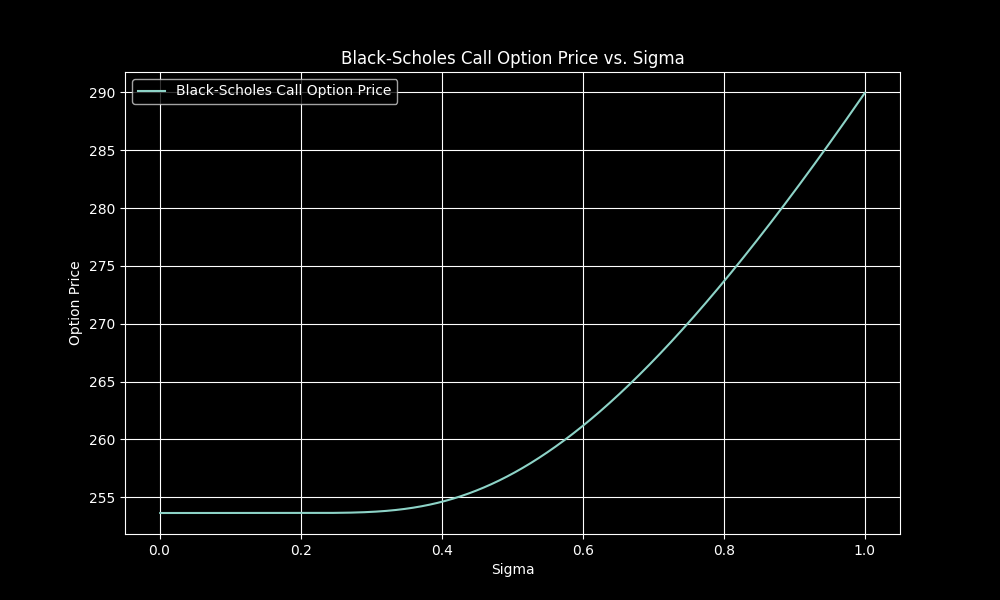

In [15]:
# Values for plotting
# sigma_values = np.linspace(0.0001, 2, 100000)  # Values of sigma from 0.001 to 2
sigma_values = np.linspace(0.001, 1, 100000)  # Values of sigma from 0.001 to 2

# Calculate call option prices for each sigma value
call_prices = [black_scholes_call(S, K, r, T, sigma) for sigma in sigma_values]

# Plot
plt.figure(figsize=(10, 6))
# Quitar el offset, saca factor común mpl de algo grande, y parece notación científica pero no es
plt.ticklabel_format( useOffset=False)
plt.plot(sigma_values, call_prices, label='Black-Scholes Call Option Price')
plt.xlabel('Sigma')
plt.ylabel('Option Price')
plt.title('Black-Scholes Call Option Price vs. Sigma')
plt.grid(True)
plt.legend()
plt.show()

#### Interpretación: 
- Primeros dato sintético por mí: En este gráfico la solución es Call(sigma) , a varios sigma obtenemos el valor del call. Entonces usando el último valor del dataset, el valor del call de la realidad debería ser 270 promedio. Buscamos un sigma lógico entre 0.1 y 3 ponele. Para 270 estamos en un sigma de 0.75 aprox.
- Primeros datos dataset (dato 700): En este gráfico la solución es Call(sigma) , a varios sigma obtenemos el valor del call. Entonces usando el último valor del dataset, el valor del call de la realidad debería ser 270 promedio. Buscamos un sigma lógico entre 0.1 y 3 ponele. Para 270 estamos en un sigma de 0.95 aprox.
- Último dato del dataset: En este gráfico la solución es Call(sigma) , a varios sigma obtenemos el valor del call. Entonces usando el último valor del dataset, el valor del call de la realidad debería ser 107 promedio. Buscamos un sigma lógico entre 0.1 y 3 ponele. NO HAY para este valor, porque el piso, la asíntota horizontal está en 178 que no llega ni a palos a 107.

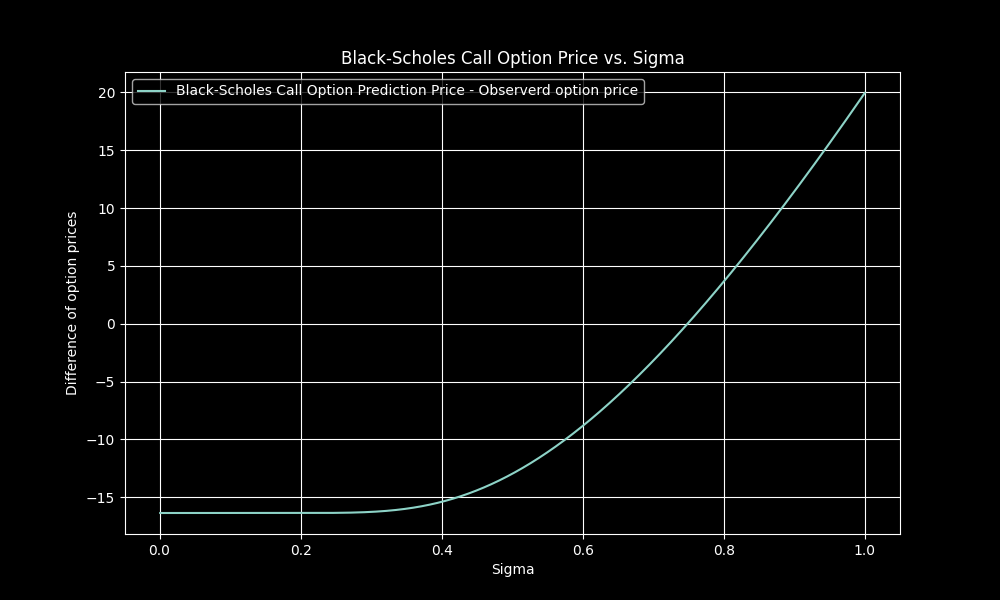

In [16]:
# Calculate function to minimize or find root (predicted_opt_price - observerd_opt_price) prices for each sigma value
sigma_values = np.linspace(0.001, 1, 100000)  # Values of sigma from 0.001 to 2
functomin = [function_to_minimize(S, K, r, T, sigma, price) for sigma in sigma_values]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(sigma_values, functomin, label='Black-Scholes Call Option Prediction Price - Observerd option price')
# Quitar el offset, saca factor común mpl de algo grande, y parece notación científica pero no es
plt.ticklabel_format( useOffset=False)
plt.xlabel('Sigma')
plt.ylabel('Difference of option prices')
plt.title('Black-Scholes Call Option Price vs. Sigma')
plt.grid(True)
plt.legend()
plt.show()

#### Interpretación:
El time to maturity está en 1 acá porque no tenía mucho peso, sí está anualizado.
- Primeros datos del dataset: En este gráfico la solución es Call(sigma) - price, a varios sigma la resta que tendría que ser parecida a cero. Usando primeros datos,el valor de la resta debería ser cero. Buscamos un sigma lógico entre 0.1 y 3 ponele. Acá para y=0 tenemos un x=sigma= 0.75 aprox que bueno está ok alta volatilidad argentina.
- Primeros datos dataset (dato 700): En este gráfico la solución es Call(sigma) - price, a varios sigma la resta que tendría que ser parecida a cero. Usando primeros datos,el valor de la resta debería ser cero. Buscamos un sigma lógico entre 0.1 y 3 ponele. Acá para y=0 tenemos un x=sigma= 0.94 aprox que bueno está ok alta volatilidad argentina.
- Últimos datos dataset: En este gráfico la solución es Call(sigma) - price, a varios sigma la resta que tendría que ser parecida a cero. Entonces usando el último valor del dataset,el valor de la resta debería ser cero. Buscamos un sigma lógico entre 0.1 y 3 ponele. NO HAY para este valor, porque el piso, la asíntota horizontal está en 72 ponele y no llega ni en pedo a cero.

### Newton raphson a mano en python

In [17]:
# Parameters
## Primeros datos dataset
# S = 1212.0       # Current stock price
# K = 1033.0       # Strike price
# r = 0.9        # Risk-free rate
# T = 1.0 * (30/360)   # Time to maturity
# price = 270.0    # Observed option price

## Primeros datos dataset (dato 700)
S = 1169.5       # Current stock price
K = 1033.0       # Strike price
r = 0.9        # Risk-free rate
T = 1.0 * (30/360)   # Time to maturity
price = 250.0    # Observed option price

## Último dato dataset
# S = 1136.5       # Current stock price
# K = 1033.0       # Strike price
# r = 0.9        # Risk-free rate
# T = 1.0 * (30/360)   # Time to maturity
# price = 107.0    # Observed option price

sqrt_0_5 = math.sqrt(0.5)
def normalCDF(z_value):
    return 0.5 * math.erfc( - (z_value * sqrt_0_5) )

def black_scholes_call(S, K, r, T, sigma):
    d1 = ( (np.log(S / K)) + ((r + (0.5 * sigma**2)) * T) ) / (sigma * np.sqrt(T))
    d2 = d1 - ( sigma * np.sqrt(T) )
    call_price = ( S * normalCDF(d1) ) - ( K * np.exp(-r * T) * normalCDF(d2) )
    return call_price

# Function to minimize
def function_to_minimize(S, K, r, T, sigma, price):
    return (black_scholes_call(S, K, r, T, sigma) - price)

def newton_iterator(S, K, r, T, price, d_sigma_est, x0=0.1, tolerance=1e-6, max_iter=100):
    # We'll use Newton-Raphson iterative method to get the sigma parameter.

    # Initialization
    sigma = x0
    print(sigma)
    d_sigma = d_sigma_est  # delta to evaluate derivative approximation

    # Main loop
    for iter in range(max_iter):
        f_sigma = function_to_minimize(S, K, r, T, sigma, price)
        if abs(f_sigma) < tolerance:
            
            print(f"Converged to root: sigma = {sigma}\nIterations: {iter}\nAt call price = {f_sigma+price}")
            return 0
        else:
            # Approximate derivative using finite symmetric difference
            f_prime_sigma = ( function_to_minimize(S, K, r, T, price, sigma + d_sigma) - (function_to_minimize(S, K, r, T, price, sigma - d_sigma)) ) / (2 * d_sigma)
            # f_prime_sigma = ( function_to_minimize(S, K, r, T, price, sigma + d_sigma) - f_sigma ) / d_sigma
            sigma = sigma - ( f_sigma / f_prime_sigma )

    print("Did not converge within max iterations.")
    return f_sigma

newton_iterator(S,K,r,T,price, d_sigma_est=1e-6, x0=0.01, tolerance=1e-6, max_iter=1000)


0.01
Did not converge within max iterations.


-1208.359021377395

##### Newton raphson no me dio resultado nunca la verdad hay que estudiarlo mejor.

### Método de bisection

In [18]:
# METODO UTULIZANDO Blackscholes call PURO (no igualando a cero)
import math
# Parameters
## Primer dato dataset
# S = 1212.0       # Current stock price
# K = 1033.0       # Strike price
# r = 0.9        # Risk-free rate
# T = 1.0 * (30/360)   # Time to maturity
# price = 270.0    # Observed option price

## Primeros datos dataset (dato 700)
S = 1169.5       # Current stock price
K = 1033.0       # Strike price
r = 0.9        # Risk-free rate
T = 1.0 * (30/360)   # Time to maturity
price = 250.0    # Observed option price

## Último dato dataset
# S = 1136.5       # Current stock price
# K = 1033.0       # Strike price
# r = 0.9        # Risk-free rate
# T = 1.0 * (30/360)   # Time to maturity
# price = 107.0    # Observed option price

sqrt_0_5 = math.sqrt(0.5)
def normalCDF(z_value):
    return 0.5 * math.erfc( - (z_value * sqrt_0_5) )

def black_scholes_call(S, K, r, T, sigma):
    d1 = ( (np.log(S / K)) + ((r + (0.5 * sigma**2)) * T) ) / (sigma * math.sqrt(T))
    d2 = d1 - ( sigma * math.sqrt(T) )
    call_price = ( S * normalCDF(d1) ) - ( K * math.exp(-r * T) * normalCDF(d2) )
    return call_price

def implied_volatility_bisection(S, K, r, T, price, lower_bound = 0.001, upper_bound = 2.0, tol=1e-6, max_iter=1000):
    # Define initial bounds for implied volatility
    sigma_low = lower_bound
    sigma_high = upper_bound

    # Ensure that observed price lies between calculated prices at initial bounds
    if price < black_scholes_call(S, K, r, T, sigma_low) or price > black_scholes_call(S, K, r, T, sigma_high):
        return None, None, None
    # Is using an "equaled to zero" funtion (callprice - price) a nice condition would be to check it

    # Bisection loop
    for iter in range(max_iter):
        sigma_mid = (sigma_low + sigma_high) / 2
        call_price_mid = black_scholes_call(S, K, r, T, sigma_mid)

        if abs(call_price_mid - price) < tol:
            return sigma_mid, call_price_mid, iter

        if call_price_mid < price:
            sigma_low = sigma_mid
        else:
            sigma_high = sigma_mid

    return None, None, None

# Find implied volatility using bisection method
implied_volatility, predicted_call_price, iter = implied_volatility_bisection(S, K, r, T, price)
if implied_volatility is not None:
    print(f"Implied Volatility: {implied_volatility:.6f}")
    print(f"Predicted Call Price: {predicted_call_price:.6f}")
    print(f"Iterations: {iter}")
else:
    print("Failed to find implied volatility within the given tolerance.")


Implied Volatility: 0.943388
Predicted Call Price: 250.000000
Iterations: 26


In [19]:
# Método usando blackscholescall - price (cero en teoría) (hay que cambiar bastante la lógica para este caso)
import math
import numpy as np

## Primer dato dataset
# S = 1212.0       # Current stock price
# K = 1033.0       # Strike price
# r = 0.9        # Risk-free rate
# T = 1.0 * (30/360)   # Time to maturity
# price = 270.0    # Observed option price

## Primeros datos dataset (dato 700)
S = 1169.5       # Current stock price
K = 1033.0       # Strike price
r = 0.9        # Risk-free rate
T = 1.0 * (30/360)   # Time to maturity
price = 250.0    # Observed option price

## Último dato dataset
# S = 1136.5       # Current stock price
# K = 1033.0       # Strike price
# r = 0.9        # Risk-free rate
# T = 1.0 * (30/360)   # Time to maturity
# price = 107.0    # Observed option price

sqrt_0_5 = math.sqrt(0.5)
def normalCDF(z_value):
    return 0.5 * math.erfc( - (z_value * sqrt_0_5) )

# Black-Scholes function returning call_price - price
def black_scholes_call_zeroed(S, K, r, T, sigma, price):
    d1 = ( (np.log(S / K)) + ((r + (0.5 * sigma**2)) * T) ) / (sigma * math.sqrt(T))
    d2 = d1 - ( sigma * math.sqrt(T) )
    call_price = ( S * normalCDF(d1) ) - ( K * math.exp(-r * T) * normalCDF(d2) )
    return call_price - price  # Return the difference between calculated call price and observed price

# Bisection method to find implied volatility
def implied_volatility_bisection(S, K, r, T, price, lower_bound = 0.001, upper_bound = 2.0, tol=1e-6, max_iter=1000):
    # Define initial bounds for implied volatility
    sigma_low = lower_bound
    sigma_high = upper_bound

    # Ensure that the observed price lies between the calculated prices at initial bounds
    # We check for the "sign", the correct value is zero 0, so for bolzano one boundarie must be negative and
    # the other one positive, giving the multipication a negative number
    if black_scholes_call_zeroed(S, K, r, T, sigma_low, price) * black_scholes_call_zeroed(S, K, r, T, sigma_high, price) > 0:
        # Return None if the bounds are not correct (i.e., no root between them)
        return None, None, None

    # Bisection loop
    for iter in range(max_iter):
        sigma_mid = (sigma_low + sigma_high) / 2
        call_price_mid = black_scholes_call_zeroed(S, K, r, T, sigma_mid, price)

        if abs(call_price_mid) < tol:
            # If the result is within tolerance, return the implied volatility
            return sigma_mid, sigma_mid, iter

        if call_price_mid < 0:
            sigma_low = sigma_mid
        else:
            sigma_high = sigma_mid

    return None, None, None

# Find implied volatility using bisection method
implied_volatility, predicted_call_price, iter = implied_volatility_bisection(S, K, r, T, price)
if implied_volatility is not None:
    print(f"Implied Volatility: {implied_volatility:.6f}")
    print(f"Predicted Call Price: {predicted_call_price:.6f}")
    print(f"Iterations: {iter}")
else:
    print("Failed to find implied volatility within the given tolerance.")


Implied Volatility: 0.943388
Predicted Call Price: 0.943388
Iterations: 26


##### Notemos que da lo que tiene que dar con el bisection method que es fácil de calcular y todo! Converge para primer dato y no para el último. También notemos que necesita tipo 25 iteraciones que computacionalmente es bastante.

## EXPLICACIÓN DATASET ENTERO FINAL

### Complete dataframe with calculated implied volatility as std

In [20]:
completedf = import_dataframe("Exp_Octubre.csv")
completedf['std_imp_vol_bs'] = completedf.apply(lambda row: implied_volatility_bisection(row['avstock'], K, r, row['time_to_maturity'], row['avopt'])[0], axis=1)
completedf


C:\Users\Agux8\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice


,description,strike,kind,bid,ask,underBid,underAsk,created_at,avopt,avstock,time_to_maturity,stdstock_instant_historical,underBid_prev,underAsk_prev,avg_current,avg_previous,stdstock_byminute_historical,std_imp_vol_bs
0,GFGC1033OC,1033,CALL,250.000,NaN,1211.15,1213.0,2023-09-08 11:28:00,250.0000,1212.075,0.117423,1.308148,NaN,NaN,1212.075,NaN,NaN,NaN
1,GFGC1033OC,1033,CALL,270.602,NaN,1211.00,1212.0,2023-09-08 11:29:00,270.6020,1211.500,0.117421,0.707107,1211.15,1213.0,1211.500,1212.075,0.406586,NaN
2,GFGC1033OC,1033,CALL,270.652,324.654,1208.00,1211.0,2023-09-08 11:30:00,297.6530,1209.500,0.117419,2.121320,1211.00,1212.0,1209.500,1211.500,1.414214,0.701615
3,GFGC1033OC,1033,CALL,281.571,322.127,1210.00,1211.0,2023-09-08 11:32:00,301.8490,1210.500,0.117415,0.707107,1208.00,1211.0,1210.500,1209.500,0.707107,0.742336
4,GFGC1033OC,1033,CALL,281.611,322.107,1211.00,1212.5,2023-09-08 11:33:00,301.8590,1211.750,0.117413,1.060660,1210.00,1211.0,1211.750,1210.500,0.883883,0.729206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3291,GFGC1033OC,1033,CALL,100.001,115.000,1139.05,1139.9,2023-10-19 14:43:00,107.5005,1139.475,0.003158,0.601041,1138.95,1139.5,1139.475,1139.225,0.176777,NaN
3292,GFGC1033OC,1033,CALL,100.001,115.000,1135.55,1137.0,2023-10-19 15:11:00,107.5005,1136.275,0.003104,1.025305,1139.05,1139.9,1136.275,1139.475,2.262742,1.069763
3293,GFGC1033OC,1033,CALL,100.001,108.000,1140.10,1142.0,2023-10-19 15:21:00,104.0005,1141.050,0.003084,1.343503,1135.55,1137.0,1141.050,1136.275,3.376435,NaN
3294,GFGC1033OC,1033,CALL,100.008,108.000,1143.00,1144.0,2023-10-19 15:25:00,104.0040,1143.500,0.003077,0.707107,1140.10,1142.0,1143.500,1141.050,1.732412,NaN


In [21]:
# Extraigo las columnas finales para la tarea en un csv
selected_columns = completedf[['stdstock_instant_historical','stdstock_byminute_historical', 'std_imp_vol_bs',]]
selected_columns.to_csv('python_selected_columns_exp_octubre.csv', index=False)
selected_columns

,stdstock_instant_historical,stdstock_byminute_historical,std_imp_vol_bs
0,1.308148,NaN,NaN
1,0.707107,0.406586,NaN
2,2.121320,1.414214,0.701615
3,0.707107,0.707107,0.742336
4,1.060660,0.883883,0.729206
...,...,...,...
3291,0.601041,0.176777,NaN
3292,1.025305,2.262742,1.069763
3293,1.343503,3.376435,NaN
3294,0.707107,1.732412,NaN


El temita es así.
ANTES DE EXPRESAR LOS TIME TO MATURITY ANUALIZADOS PROPIAMENTE:
Para valores tempranos (hasta indice 630 ponele, 2023-09-19T11:12:00.0), el bisection method no converge sobre algunos de los datos crudos así nomás porque hay unos pocos puntos sin precio de "ask" (de las opciones)
entonces el promedio que con el valor de bid que está muy bajo y ya el modelo medio que no aplica a ese valor de opcion, pero para muchos converge.
EN CAMBIO para valores TARDIOS (indice 1960 aprox, 2023-10-04T12:20:00.000), están todos los valores disponibles sin nan, pero lo que INTUYO que ocurre es que empieza a pesar
el time to maturity ahí.

DESPUÉS DE ANUALIZAR ADECUADAMENTE TODOS LOS TIME TO MATURITY:
UNA VEZ corregidos sobre todo los time to maturity, quedan algunos datos para los que no hay solución, mala suerte.
HABRÍA que evaluar si es porque tienen nan es ask o bid. A OJO los primerso sí (no convergen por no tener precio de bid o de ask), pero los últios no convergen igualmente y es por un tema de MODELO, pero opino que ya no hay nada que hacer para esto, nomás pondría un EJEMPLO de qué sucede y a la mierda.

TESTEAR TRADING YEARS CON BLACKSCHOLES A VER QUE DA.

#### Buscamos cuantos datos quedaron sin poder calcularse la volatilidad implícita.

In [22]:
# Conteo de NaN es avopt (por hacer mal promedio)
# con average malos para avopt, teníamos 1304 aprox nans
# con average bien ignorando nan, tenemos 1290 nans (poca diferencia por ende)
# corrigiendo time to maturity a lo que debe ser en años (pasando días a años), bueno tenemos 273
# corrigiendo time to maturity a lo que debe ser en años (pasando segundos totales a años), bueno tenemos 285 (emepeoró JAJ)
completedf[np.isnan(completedf["std_imp_vol_bs"])].index.size

285

#### Buscamos si quedó algun dato sin poderse calcular su stock price (que al principio no estaban todos). No debería quedar ninguno sin calcular.

In [23]:
completedf[np.isnan(completedf["avstock"])].index.size

0

### Analysis for mean volatilities obtained
It's convenient to analyze the mean of every volatility obtained by minute by taking it's mean and standard deviations to see if they compare.
Two ways of estimating historical volatility were used:
- "instant historical volatility": It is measured as the sample standard deviation of "underBid" and "underAsk" values of the same minute, we could think is it as similar approach to a "range" of values.
- "by minute historical volatility": It is measured as the standard deviation of the values between the actual minute and the previous minute. The values taken into account for each minute are the mean of underBid and underAsk prices. A few points are not "minute" deviations because dataframe has some jumps in time (when there are weekends or holidays) but won't interfere as much in the analysis as they are few and it's values won't escape the deviation of the popoulation.

In [24]:
# Let's do a summary with averages of the calculated volatilities
columns = ['stdstock_instant_historical','stdstock_byminute_historical', 'std_imp_vol_bs']
# Creating the DataFrame
summary = pd.DataFrame(columns=columns)
# Adding a row for mean and standard deviation
summary.loc['mean'] = completedf[columns].mean()
summary.loc['std %'] = completedf[columns].std() * 100
summary

,stdstock_instant_historical,stdstock_byminute_historical,std_imp_vol_bs
mean,2.214579,1.581371,0.864364
std %,547.256315,287.457554,20.385036


In [25]:
# Let's do a summary with averages of the calculated volatilities. FOR CPP made file for comparison
columns = ['stdstock_instant_historical','stdstock_byminute_historical', 'std_imp_vol_bs']
# Creating the DataFrame
selected_columns_df_from_cpp = pd.read_csv("./cpp_selected_columns_exp_octubre.csv")
selected_columns_df_from_cpp.columns = columns
summary2 = pd.DataFrame(columns=columns)
# Adding a row for mean and standard deviation
summary2.loc['mean'] = selected_columns_df_from_cpp[columns].mean()
summary2.loc['std %'] = selected_columns_df_from_cpp[columns].std() * 100
summary2

,stdstock_instant_historical,stdstock_byminute_historical,std_imp_vol_bs
mean,2.214854,1.581371,0.864364
std %,547.337890,287.457557,20.385041


As analysis, we could say that black-scholes prediction is less disperse, logically the model itself assumes that volatility is constant over time, so values obtained vary as far as 20% from mean in most cases (as 1 std).
In contrast, historical volatilies are way more disperse having and dispersion of 290% and 550% (as relative std) which could makes us doubt even if this results could have normal distribution.
Because of this enormous difference in dispersion results are not really comparable, most parametric statistic tests would require normality and homoscedasticity (same variance) which are clearly different.
We could only conclude that as an analysis of pure exactness historical volatilies are at least 2 times bigger, but again the huge dispersions simply implies that black-scholes is not representative of reality.
Also black-schoels is a model for european options (they could only excercise on expiration date, in contrast to american options that can excersice any time before), and we are dealing with american-type options, but on most cases it estimates well with simpler mathematics, since the aren't usually reasons to excercise much before expiry date, so we could expect differences but not they would probably not be that big (it would solve integrals in the black scholes equation by numerical methods instead of having a pre-made formula).
Anyways black-scholes is at least a starting point of prediction and possibly would be a good theoritical framework for a hybrid model where differences with theory might be fitted with statiscal methods giving a more extrpolable model.

In [26]:
# Verificación de que el dataframe obtenido con c++ era equivalente. HAY MENORES diferencias en decimales pero muy mínimas.
# cpp_full = pd.read_csv("cpp_full.csv", header=None)
# cpp_full.columns = ["bid", "ask","underBid","underAsk", "avopt", "avstock", "std_instant_historical", "under_Bid_prev", "under_Ask_prev", "avstockprev","std_by_minute" ,"created_at_seconds","time_to_maturity_years", "bisection_results"]
# cpp_full

In [27]:
# cpp_full["std_python"] = cpp_full[["underBid","underAsk"]].std(axis=1, ddof=1)
# cpp_full["std_python"]

### Analysis with Annualized historical volatilies
I think it's not coherent to annualize the volatility obtained from minute, if we are at least estimating that volatility won't change that much in a period.
The typical method to annualize volatility by multypling by a factor is the assumption that volatility would increase linearly over time by a factor (and a big one) which makes no sense with current assumptions and make results hard to compare (annualized data would be much bigger).
But we do it anyways to show it's effect.
We supose we have trading years of 252 days, with 6h of trading per days, and 60 minutes per hour which are typical estimatations in annualization.
The factor to correct the volatilities will include a square root of the time for taking into account that we are dealing with standard
deviations instead of variance (variance is the measure of dispersion that behave lineraly).

In [28]:
# Let's create a copy Df from the complete one with the volatilies
# so that we annualize the each point of estimated minute volatilies
columns = ['stdstock_instant_historical','stdstock_byminute_historical', 'std_imp_vol_bs']
stddf = pd.DataFrame(data=completedf, columns=columns)
# Let's annualize each desired data point
stddf['stdstock_instant_historical'] = stddf['stdstock_instant_historical'] * 301.7
stddf['stdstock_byminute_historical'] = stddf['stdstock_byminute_historical'] * 301.7
# Adding a row for mean and standard deviation
stddf.loc['mean'] = stddf[columns].mean()
# Let's annualize the means
stddf.loc['std %'] = completedf[columns].std() * 100
# Let's annualize here

# Let's do a summary with averages of the calculated volatilities
# Creating the DataFrame
summary = pd.DataFrame(columns=columns)
# Adding a row for mean and standard deviation
summary.loc['mean'] = stddf[columns].mean()
summary.loc['std %'] = stddf[columns].std() * 100
summary

,stdstock_instant_historical,stdstock_byminute_historical,std_imp_vol_bs
mean,668.101720,477.042056,0.870843
std %,165057.278876,86700.256528,40.987586


Conclusion of this the real annualized volatilies do not make any sense being hundreds of orders of magnitude away.

### Coherent analysis of data
A more relevant analysis would be to estimate volatility from a bigger period instead of minute data.
The standard deviation of only two points per minute is not that representative of reality, it would be an OK estimate if analizing times in a minute,
but would crearly fail when extrapolating that result to another time period like years.
Although Black-Scholes would do the same in this case, black-scholes is usually used with some success with at least day data, which would extrapolate to a year much better
than minute. 
Black-scholes formula would estimate the volatility as a constant which we know from reality that volatility varies heavily in time, but also considers stochastic movement of stock prices, being the today's price (and it's similar values to say for example in one standard deviation) the most probable future values, so under this hypothesis the model is congruent with itself and expects less variation of volatility values from different data points.

Also the model won't preddict the call price for all the real-life dataset values:
- Black-scholes formula (as a function of sigma) is an asinthotic sigmoid function, it will present clear asymptotes when plotting representing that ends up representing global maxima and minima.
- Black-scholes formula (as a function of sigma) is a monothonic increasing function, which excludes the posibility of local maxima and minima.
This traits makes the value of the Call prices (function) easy to solve by any simple numerical method, but will never solve if function with real life parameters has minima
that never reach the observed call price. In other words the best prediction of the model might not match with reality by the minima and maxima defined by it's asymptotes. So in our case 284 points (of the 3296) are left out of the analysis because no sigma can solve the equation for those values (we could get an alternative analysis by taking the value of the minima asymptote instead of leaving the point, not done in this study).


A proposed better analysis would simply take into account having an annualized historical volatitity estimated the whole dataset, which would translate int a 1.5 months period (that extrapolate better to a year than a minute) and analizing these averages, not locking to minute data.
We do that next




In [29]:
completedf.index.size

3296

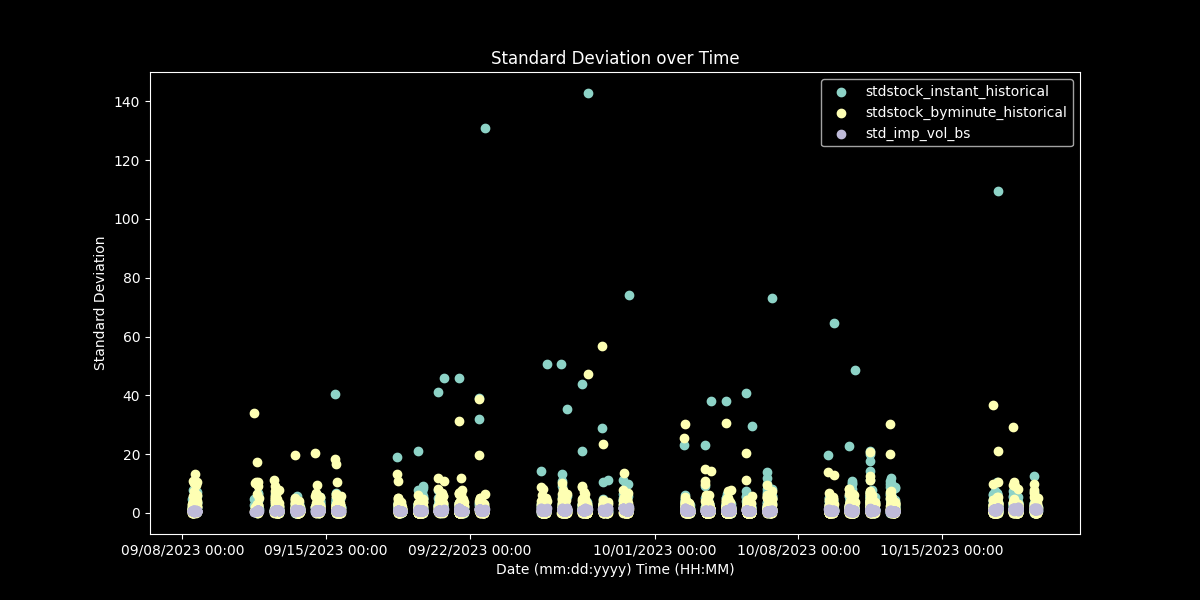

In [30]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# myFmt = mdates.DateFormatter('%m/%d/%Y %H:%M')

# Convert 'created_at' column to datetime with explicit format
completedf['created_at'] = pd.to_datetime(completedf['created_at'], format='%m/%d/%Y %H:%M')

# Plot the data
fig, ax1 = plt.subplots(figsize=(12, 6))

# Let's put the right format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y %H:%M'))

# Plot stdstock_instant_historical
ax1.scatter(completedf['created_at'], completedf['stdstock_instant_historical'], label='stdstock_instant_historical')

# Plot stdstock_byminute_historical
ax1.scatter(completedf['created_at'], completedf['stdstock_byminute_historical'], label='stdstock_byminute_historical')

# Plot std_imp_vol_bs
ax1.scatter(completedf['created_at'], completedf['std_imp_vol_bs'], label='std_imp_vol_bs')

# Add labels and title
ax1.set_xlabel('Date (mm:dd:yyyy) Time (HH:MM)')
ax1.set_ylabel('Standard Deviation')
ax1.set_title('Standard Deviation over Time')

# Show plot
plt.legend()
plt.show()


### Lineplot

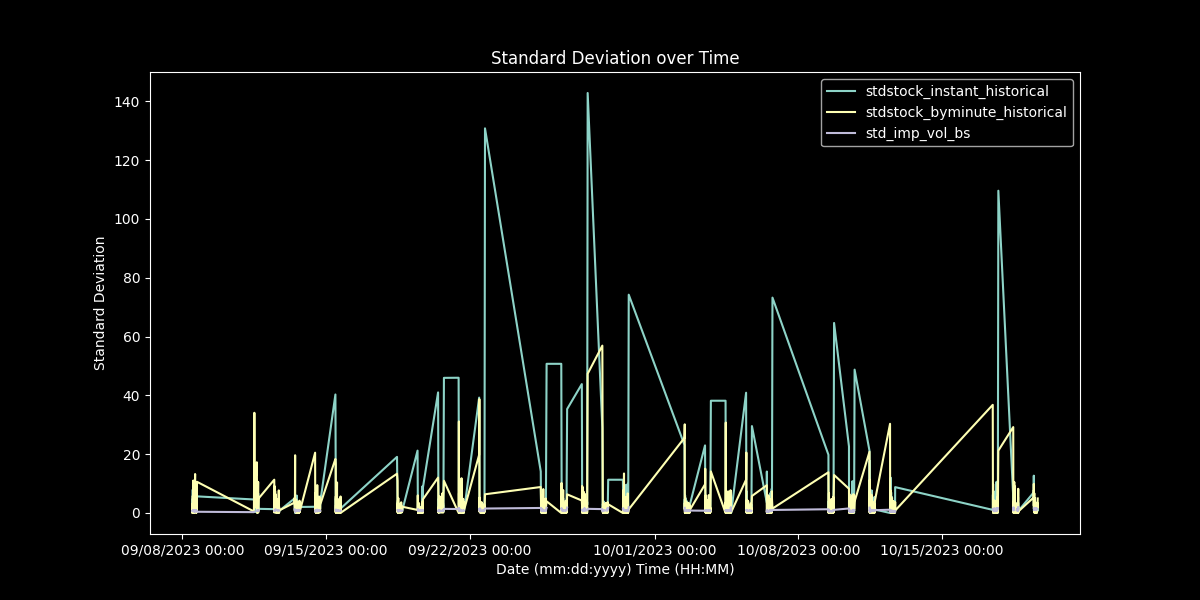

In [31]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert 'created_at' column to datetime with explicit format
completedf['created_at'] = pd.to_datetime(completedf['created_at'], format='%m/%d/%Y %H:%M')

# Plot the data
fig, ax1 = plt.subplots(figsize=(12, 6))

# Let's put the right format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y %H:%M'))

# Plot stdstock_instant_historical
ax1.plot(completedf['created_at'], completedf['stdstock_instant_historical'], label='stdstock_instant_historical')

# Plot stdstock_byminute_historical
ax1.plot(completedf['created_at'], completedf['stdstock_byminute_historical'], label='stdstock_byminute_historical')

# Plot std_imp_vol_bs
ax1.plot(completedf['created_at'], completedf['std_imp_vol_bs'], label='std_imp_vol_bs')

# Add labels and title
ax1.set_xlabel('Date (mm:dd:yyyy) Time (HH:MM)')
ax1.set_ylabel('Standard Deviation')
ax1.set_title('Standard Deviation over Time')

# Show plot
plt.legend()
plt.show()


### Scatter, only byminute historical

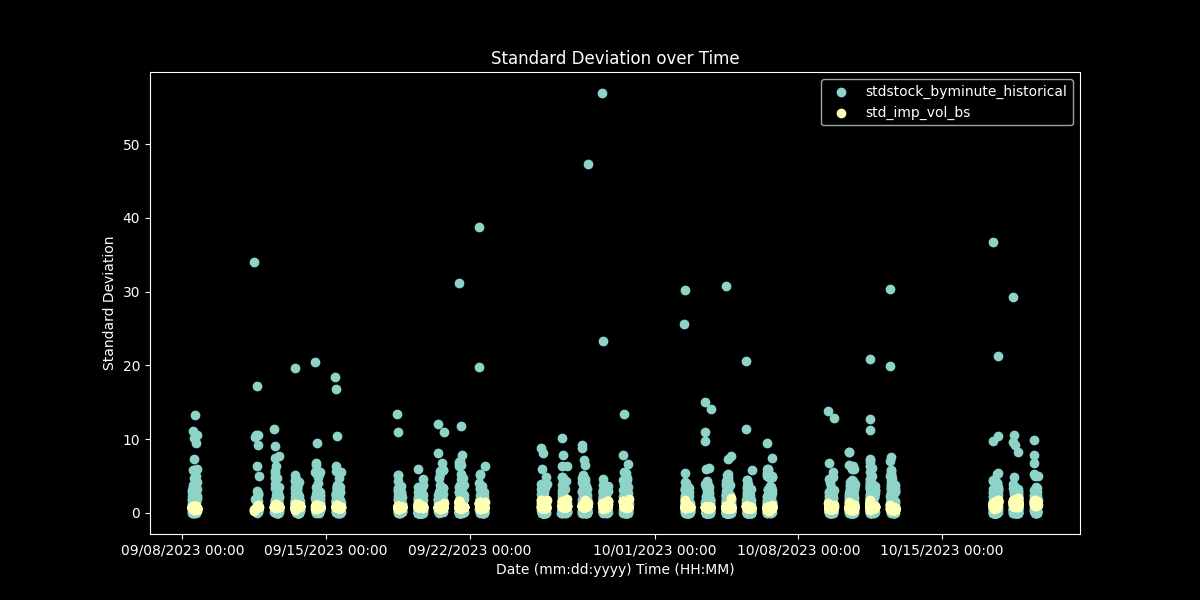

In [32]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# myFmt = mdates.DateFormatter('%m/%d/%Y %H:%M')

# Convert 'created_at' column to datetime with explicit format
completedf['created_at'] = pd.to_datetime(completedf['created_at'], format='%m/%d/%Y %H:%M')

# Plot the data
fig, ax1 = plt.subplots(figsize=(12, 6))

# Let's put the right format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y %H:%M'))

# Plot stdstock_byminute_historical
ax1.scatter(completedf['created_at'], completedf['stdstock_byminute_historical'], label='stdstock_byminute_historical')

# Plot std_imp_vol_bs
ax1.scatter(completedf['created_at'], completedf['std_imp_vol_bs'], label='std_imp_vol_bs')

# Add labels and title
ax1.set_xlabel('Date (mm:dd:yyyy) Time (HH:MM)')
ax1.set_ylabel('Standard Deviation')
ax1.set_title('Standard Deviation over Time')

# Show plot
plt.legend()
plt.show()


### Lineplot, only by minute

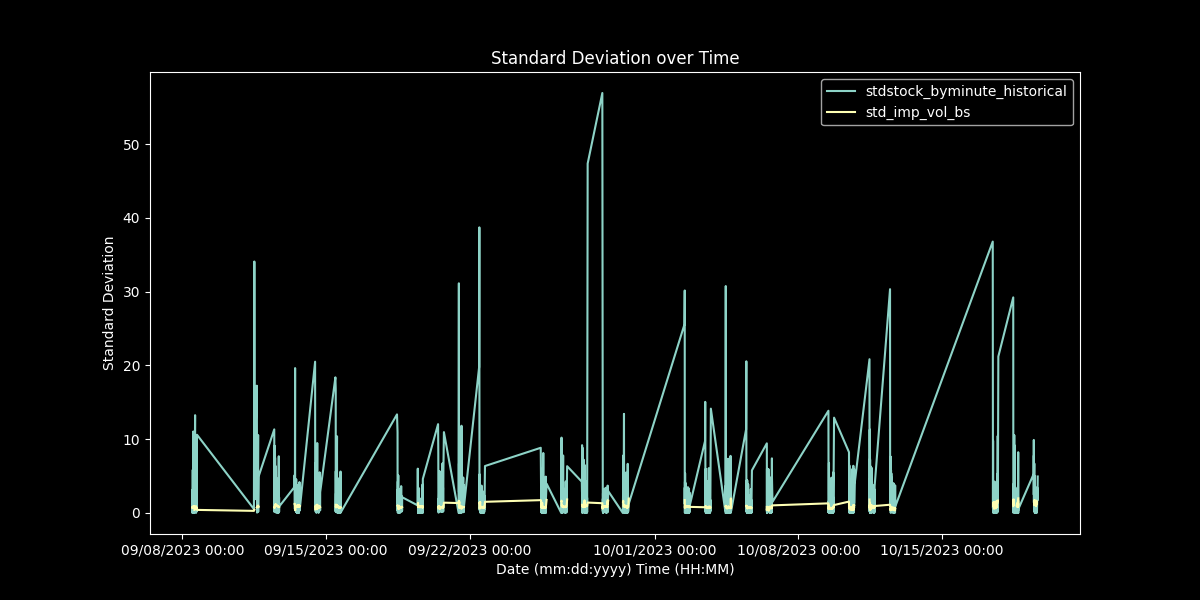

In [33]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert 'created_at' column to datetime with explicit format
completedf['created_at'] = pd.to_datetime(completedf['created_at'], format='%m/%d/%Y %H:%M')

# Plot the data
fig, ax1 = plt.subplots(figsize=(12, 6))

# Let's put the right format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y %H:%M'))

# Plot stdstock_byminute_historical
ax1.plot(completedf['created_at'], completedf['stdstock_byminute_historical'], label='stdstock_byminute_historical')

# Plot std_imp_vol_bs
ax1.plot(completedf['created_at'], completedf['std_imp_vol_bs'], label='std_imp_vol_bs')

# Add labels and title
ax1.set_xlabel('Date (mm:dd:yyyy) Time (HH:MM)')
ax1.set_ylabel('Standard Deviation')
ax1.set_title('Standard Deviation over Time')

# Show plot
plt.legend()
plt.show()

### Por qué C o C++ no son las herramientas para este problema?
Sin duda es de esperar que nos llevará más tiempo que con cualquier lenguaje interpretado, pero va mucho más allá de ser un problema de sintaxis y manejo manual de memoria, es la falta de optimización para datos lo que lo hace fallar al no exisitir herramientas de manejo comunes para los mismos. 
- No hay interpretación alguna de las fechas, el cuál es el tipo de datos más problemático para trabajar, necesita una separación muy manual de las mismas a través de strings y manipulación.
- Los cálculos pueden ser muy complejos de realizar a mano aunque no parezca.
- Compilación : Si se desean usar librerías se pueden tardar más tiempo en aprender a compilar que en usarlas, caemos en la practicidad de intentar utlizar librerías header.-only a costa de tiempo de compilación alto.
- Lectores de CSV: NO hay lectores de CSV que permitan interpretación automática de la mayoría de los datos. Hay pocos y pueden no manejar datos erróneos o atípicos,
si el lector es bueno muy seguramente no se integra con otra librería para realizar cálculos. (rapidcsv utilicé yo)
- Ausencia de labeling: NO hay integración de los lectores ni librerías de cálculos que realicen cálculos con "labeled data", hace incómodo el acceso a los datos y obliga a pensarlos como columnas ordenadas como números.
- Integración con cálculos: Las librerías de cálculos no se integran adecuadametne con las que leen csv o tienen lectores paupérrimos y complejos, como ser Eigen, Aramdillo y xtensor (usé la última), sumado a la ausencia de labeling. Estas últimas van a manejar únicamente números y darán problemas o directamente no funcionarán con columnas con strings o booleanos. Necesita una sepración de ambas partes. Adicionalmente concentrarnos en datos numéricos puede hacernos caer en data leaks por falta de una visión global.
- Manipulación mínima para datos NaN y datos erróneos: C tiene varios tipos de NaN (en std y limits, sumado a los tipo quiet y signaling, también es común el "-nan"), sumado a que quizá no interpreta fácilmente cualquier tipo de dato que se salga de un int o float como NaN lo que requiere mucha intereptación manual. Las librerías manejan cada una su tipo de NaN y pueden interpretar o no otros tipos de datos como NaN.
- Complejidad para tomar en cuenta o no NaN en cálculos: Por la complejidad de la interpretación de datos NaN anterior es dificil tomar una decisión dacercar de promediar o no tomar en cuenta datos NaN, o se hacen a mano a parte con algun "if", o se maneja directo con la librería que quizá no haga lo que nosotros queramos, pero es dificil mezclar ambas cosas.
- Ausencia de herramientas de trabajo rápido - Notebooks: Si bien se pueden usar notebooks de C++ , esto son incómodos ya que tienen problemas de sobre-escritura en la memoria y requiere reseteo de su kernel constante.
- Complejidad para visualización: Las librerías de visualización están hechas principalmente para los notebooks utilizando JavaScript, lo cuál está ok para un notebook, pero no si se desea compilar un código.

Soluciones:
- Python es claramente la herramienta óptima cubriendo todos los ítems mencionados anteriormente.
- Sin tocar un sólo lenguaje este problema mismo se resuelve mucho más rápido usando excel junto a sus filtros y limpiando el dataset a mano, se puede graficar dentro del mismo sin preocuparse tanto en datos erróneos, y tiene herramientas iterativas (aunque malas) que podrían se reemplazadas por otro programa con el dataset limpio.
- Pero si nuestra preocupación es performance a largo plazo e integrar todo en uno podríamos usar Go que tiene abundantes librerías para data science integradas, notebooks y compilación sencilla y multiplataforma.

### Conclusiones
La volatilidad predicha con Black-Scholes tiene una media de 0,8 con desvío estándar de un 20% , es una precisión razonable.
Pero la realidad estimando la